In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Load Data
dataset_path = "/Users/jon/development/university/sis/datasets/output"

tfrecs_paths = [each for each in os.listdir(dataset_path) if each.endswith(".tfrecord")]

print(tfrecs_paths)

NUM_CLASSES = 26

x_dataset = []
y_dataset = []

raw_dataset = tf.data.TFRecordDataset([os.path.join(dataset_path, each) for each in tfrecs_paths])
print(raw_dataset)

feature_description = {
    'target_label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'landmarks': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
}

def parse_record_fn(example):
    return tf.io.parse_single_example(example, feature_description)

parsed_dataset = raw_dataset.map(parse_record_fn)
# print(parsed_dataset)

for parsed_record in parsed_dataset:
    x_dataset.append(parsed_record['landmarks'].numpy())
    y_dataset.append(parsed_record['target_label'].numpy())
    

['train_0009_588d5787-029b-4bdb-a7a7-851aef1509d3.tfrecord', 'train_0004_8e7afd3c-0ea9-4f03-b6f3-c1ca31335b2b.tfrecord', 'train_0008_389f87f6-d4e6-4241-ab71-49f82264970b.tfrecord', 'train_0023_6a6dee11-1db8-4c69-8b10-98093f6b71e1.tfrecord', 'train_0019_fc769ece-f77f-411b-aee5-98265e60314f.tfrecord', 'train_0017_eade0f39-4c5b-4463-aaef-983df70a3cf3.tfrecord', 'train_0002_1e88a48a-caf1-4724-bd0e-1a4a2a30ff7b.tfrecord', 'train_0012_734c63fe-bbaf-4a47-848b-cf4adc47edff.tfrecord', 'train_0015_0909de1b-78bd-4081-9dec-d048b2bb1423.tfrecord', 'train_0022_c405f7b6-ff36-4d06-a80d-8730575b74a6.tfrecord', 'train_0018_e4f52d2a-98f2-4bfc-9423-c69e73b4543b.tfrecord', 'train_0014_5ef4ad63-c685-40ae-aeef-570b02d2c7cd.tfrecord', 'train_0025_4c064d45-8241-4be9-8934-7b1e73d182ac.tfrecord', 'train_0021_055b08c6-ca36-403c-83ef-cb6c9de7b511.tfrecord', 'train_0024_ad2b9804-4fdb-45ed-9c3d-5147381c216c.tfrecord', 'train_0005_bf435c55-1475-4db9-8b60-0da3b5b8d43f.tfrecord', 'train_0016_1214a5ed-e926-421b-a930-701

In [54]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=0xdeadbeef)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)

(5818, 99, 1)
(5818, 26)


In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=x_train.shape[1:]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 99, 32)            192       
                                                                 
 conv1d_19 (Conv1D)          (None, 99, 32)            5152      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 conv1d_20 (Conv1D)          (None, 49, 64)            10304     
                                                                 
 conv1d_21 (Conv1D)          (None, 49, 64)            20544     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 24, 64)           0         
 1D)                                                  

In [56]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data=(x_test, y_test))
model.save('model-weights.h5')

Epoch 1/25


182/182 [==============================] - 5s 22ms/step - loss: 2.6327 - accuracy: 0.1825 - categorical_accuracy: 0.1825 - val_loss: 2.0417 - val_accuracy: 0.3155 - val_categorical_accuracy: 0.3155
Epoch 2/25
182/182 [==============================] - 4s 21ms/step - loss: 1.2079 - accuracy: 0.5641 - categorical_accuracy: 0.5641 - val_loss: 0.7332 - val_accuracy: 0.7402 - val_categorical_accuracy: 0.7402
Epoch 3/25
182/182 [==============================] - 4s 22ms/step - loss: 0.4970 - accuracy: 0.8278 - categorical_accuracy: 0.8278 - val_loss: 0.3444 - val_accuracy: 0.8447 - val_categorical_accuracy: 0.8447
Epoch 4/25
182/182 [==============================] - 5s 26ms/step - loss: 0.2645 - accuracy: 0.9087 - categorical_accuracy: 0.9087 - val_loss: 0.1874 - val_accuracy: 0.9045 - val_categorical_accuracy: 0.9045
Epoch 5/25
182/182 [==============================] - 5s 26ms/step - loss: 0.2150 - accuracy: 0.9276 - categorical_accuracy: 0.9276 - val_loss: 0.1151 - val_accuracy: 0.9505 -

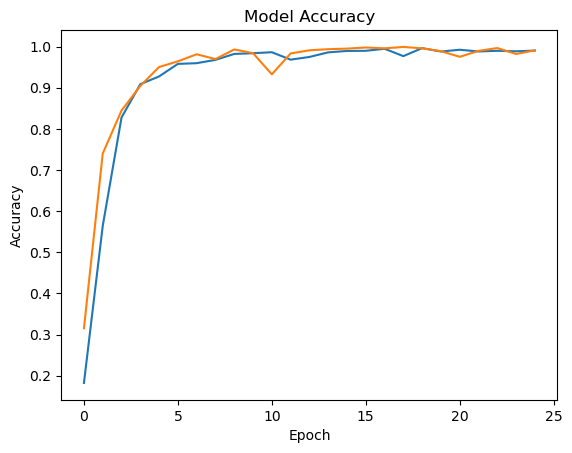

In [57]:
# Graph Metrics/History
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [69]:
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

import cv2 as cv

image = cv.imread("/Users/jon/development/university/sis/videos/alphabet/h/frame_0192.png")

from data.inference_testing.landmarks import LandmarkProcessor

processor = LandmarkProcessor(
    pose_landmarker="/Users/jon/development/university/sis/models/pose_landmarker_full.task",
    hand_landmarker="/Users/jon/development/university/sis/models/hand_landmarker.task",
    face_landmarker="/Users/jon/development/university/sis/models/face_landmarker.task"
)

collected_landmarks=[
    [12, 14, 16, 18, 20, 22, 11, 13, 15, 17, 19, 21],
    list(range(0, 21)), 
    []]

pose_landmarks, hand_landmarks, handedness, _ = processor.get_landmarks(image)

landmarks = []
landmarks.extend(hand_landmarks[0][i].x for i in collected_landmarks[1])
landmarks.extend(pose_landmarks[i].y for i in collected_landmarks[0])

landmarks.extend(hand_landmarks[0][i].y for i in collected_landmarks[1])
landmarks.extend(pose_landmarks[i].y for i in collected_landmarks[0])

landmarks.extend(hand_landmarks[0][i].z for i in collected_landmarks[1])
landmarks.extend(pose_landmarks[i].z for i in collected_landmarks[0])

landmarks = np.array(landmarks)

landmarks = np.reshape(landmarks, (1, landmarks.shape[0], 1))
prediction = model.predict(landmarks)

cats = np.zeros((1, NUM_CLASSES))
cats[np.arange(1), np.argmax(prediction)] = 1
print(cats)

1/1 [==============================] - 0s 28ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


W0000 00:00:1697799399.596096       1 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(lite_model)